In [1]:
import datetime
import os
import random
from collections.abc import Generator
from decimal import Decimal

os.chdir('/code')

import cvxpy as cp
import numpy as np
import pandas as pd

from auction_engine import engine
from auction_engine.one_inch import (
    API as one_inch_api,
    ReferenceRate,
    UnknownTokenError,
    get_reference_rate,
)
from auction_engine.models import LimitOrder

In [2]:
# Auction parameters:
from_token = 'ETH'
to_token = 'USDT'

In [3]:
reference_rate = get_reference_rate(from_token, to_token, amount=1)
reference_rate

ReferenceRate(1209.467102 USDT/ETH)

In [33]:
def generate_limit_orders(
    order_id_generator: Generator[None, None, int],
    wallet_id_generator: Generator[None, None, int],
    from_token: str,
    to_token: str,
    base_rate: ReferenceRate,
    min_amount: int = 1,
    max_amount: int = 1000,
) -> list:
    if from_token not in one_inch_api.tokens:
        raise UnknownTokenError(from_token)
    if to_token not in one_inch_api.tokens:
        raise UnknownTokenError(to_token)
    
    rate_pair = (base_rate.from_token, base_rate.to_token)

    match (from_token, to_token):
        case (base_rate.from_token, base_rate.to_token):
            # BUY
            rate = base_rate.rate
        case (base_rate.to_token, base_rate.from_token):
            # SELL
            rate = base_rate.rate**-1
        case _:
            raise ValueError(f'Unrecognized base_rate pair: {rate_pair}') 

    orders = [
        LimitOrder(
            order_id=order_id,
            wallet_id=wallet_id,
            from_token=from_token,
            to_token=to_token,
            from_token_amount=random.randint(min_amount, max_amount),
            sent_timestamp=datetime.datetime.utcnow(),
            rate_upper_limit=Decimal(random.uniform(-0.1, 0.01) + 1) * rate,
            rate_lower_limit=Decimal(random.uniform(-0.2, -0.1) + 1) * rate,
        )
        for order_id, wallet_id, in zip(
            order_id_generator,
            wallet_id_generator,
        )
    ]
    return orders

num_buys = 200
num_sells = 200

buy_gen = range(num_buys)
sell_gen = range(num_buys, num_buys + num_sells)

buy_orders = generate_limit_orders(
    order_id_generator=buy_gen,
    wallet_id_generator=buy_gen,
    from_token=from_token,
    to_token=to_token,
    base_rate=reference_rate,
)
sell_orders = generate_limit_orders(
    order_id_generator=sell_gen,
    wallet_id_generator=sell_gen,
    from_token=to_token,
    to_token=from_token,
    base_rate=reference_rate,
)
all_orders = buy_orders + sell_orders

order_book = pd.DataFrame.from_records([order.dict() for order in all_orders])
order_book

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit
0,0,0,ETH,USDT,477,2022-06-25 21:31:48.777406,1159.864211772433228543882189,986.2681678437901992666843043
1,1,1,ETH,USDT,979,2022-06-25 21:31:48.777607,1172.224799743751082736660241,1020.714106714642447754481047
2,2,2,ETH,USDT,957,2022-06-25 21:31:48.777669,1196.359157628030190180927317,1028.794023714837810059045564
3,3,3,ETH,USDT,519,2022-06-25 21:31:48.777712,1213.546623659310538521006517,1043.925876154611113736200290
4,4,4,ETH,USDT,751,2022-06-25 21:31:48.777753,1205.006087794301071230815170,1086.394304907185109116206645
...,...,...,...,...,...,...,...,...
395,395,395,USDT,ETH,261,2022-06-25 21:31:48.797556,0.0007529779572534237360224628033,0.0006661460269997476442082817650
396,396,396,USDT,ETH,450,2022-06-25 21:31:48.797603,0.0007639910141960707942467243059,0.0007190952460234983423932047583
397,397,397,USDT,ETH,188,2022-06-25 21:31:48.797653,0.0007793306631612344278085246073,0.0006848237035584703736435961042
398,398,398,USDT,ETH,901,2022-06-25 21:31:48.797701,0.0008242062515832114026454457761,0.0007188415193551188203931722492


In [107]:
standard_pair = f'{from_token}/{to_token}'
order_book['pair'] = order_book['from_token'] + '/' + order_book['to_token']
fltr_standard_pair = order_book['pair'].eq(standard_pair)

for rate in ['rate_upper_limit', 'rate_lower_limit']:
    standard_rate = order_book[rate].copy()
    standard_rate[~fltr_standard_pair] = -standard_rate.loc[~fltr_standard_pair].pow(-1)
    order_book[f'standard_{rate}'] = standard_rate

order_book['standard_pair'] = standard_pair
order_book['standard_amount'] = order_book['from_token_amount']
order_book['side'] = order_book['pair'].map({standard_pair: 'BUY'}).fillna('SELL')
order_book.sort_values('side')

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill,fill_status,fill_pct
0,0,0,ETH,USDT,477,2022-06-25 21:31:48.777406,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,477,BUY,477.0,partial,1.0
127,127,127,ETH,USDT,932,2022-06-25 21:31:48.784456,1145.482540976875546907655767,1134.027715567106781264650479,ETH/USDT,1145.482540976875546907655767,1134.027715567106781264650479,ETH/USDT,932,BUY,932.0,partial,1.0
128,128,128,ETH,USDT,597,2022-06-25 21:31:48.784485,1140.142038172978493750199469,1128.740617791248698686201937,ETH/USDT,1140.142038172978493750199469,1128.740617791248698686201937,ETH/USDT,597,BUY,597.0,partial,1.0
129,129,129,ETH,USDT,93,2022-06-25 21:31:48.784518,1195.753174600059095405912402,1183.795642854058493831431628,ETH/USDT,1195.753174600059095405912402,1183.795642854058493831431628,ETH/USDT,93,BUY,93.0,partial,1.0
130,130,130,ETH,USDT,434,2022-06-25 21:31:48.784547,1120.421469229987742781353699,1109.217254537687855402198463,ETH/USDT,1120.421469229987742781353699,1109.217254537687855402198463,ETH/USDT,434,BUY,434.0,partial,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,269,269,USDT,ETH,678,2022-06-25 21:31:48.792125,0.0008086001221453893914703200142,0.0008005141209239354903738050275,USDT/ETH,-1236.705229955674158541101922,-1249.197201975428454177981706,ETH/USDT,678,SELL,678.0,None,1.0
270,270,270,USDT,ETH,449,2022-06-25 21:31:48.792148,0.0008238022804431897101078919463,0.0008155642576387578056899789509,USDT/ETH,-1213.883505471749023449199343,-1226.144955021968721555105281,ETH/USDT,449,SELL,449.0,None,1.0
271,271,271,USDT,ETH,879,2022-06-25 21:31:48.792170,0.0008316230080330776108075514747,0.0008233067779527468273131798693,USDT/ETH,-1202.467933595489500555001176,-1214.614074338878294285799260,ETH/USDT,879,SELL,879.0,None,1.0
261,261,261,USDT,ETH,845,2022-06-25 21:31:48.791933,0.0008046985555426690644869777105,0.0007966515699872423666949490194,USDT/ETH,-1242.701373218725872272395834,-1255.253912342147356991202218,ETH/USDT,845,SELL,845.0,None,1.0


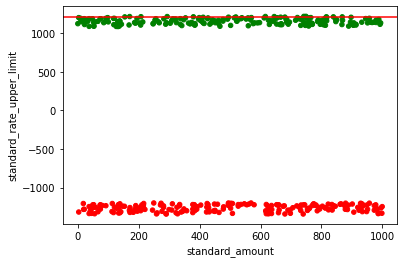

In [108]:
plt = order_book.plot.scatter(
    x='standard_amount',
    y='standard_rate_upper_limit',
    c=order_book['side'].replace({'BUY': 'green', 'SELL': 'red'}),
)
plt.axhline(y=reference_rate.rate, color='r', linestyle='-')


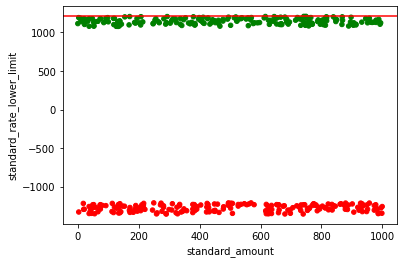

In [109]:
plt = order_book.plot.scatter(
    x='standard_amount',
    y='standard_rate_lower_limit',
    c=order_book['side'].replace({'BUY': 'green', 'SELL': 'red'}),
)
plt.axhline(y=reference_rate.rate, color='r', linestyle='-')

In [110]:
# Optimization problem
notional = reference_rate.rate * order_book['standard_amount']
side = order_book['side'].map({'BUY': 1, 'SELL': -1}).values

n = len(order_book)
x = cp.Variable(n)                                              # Auction fill quantity
p_h = order_book['standard_rate_upper_limit'].values            # upper bound
p_l = order_book['standard_rate_lower_limit'].values            # lower bound
w = side                                                        # "Portfolio" weights
q = order_book['standard_amount'].values                        # Order quantity

D = np.diag((p_h - p_l) / (2 * q))
objective = cp.Maximize(x @ p_h - cp.quad_form(x, D))
constraints = [
    x @ w == 0,
    x >= 0,
    x <= q,
]
problem = cp.Problem(objective, constraints)
problem.solve()

31433.95877900878

In [111]:
(p_l > p_h).any()

False

In [112]:
clearing_price = problem.constraints[0].dual_value
clearing_price

array(1210.55736939)

In [113]:
reference_rate

ReferenceRate(1209.467102 USDT/ETH)

In [114]:
order_book['optimal_fill'] = x.value

order_book.head()

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill,fill_status,fill_pct
0,0,0,ETH,USDT,477,2022-06-25 21:31:48.777406,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,477,BUY,9.974660e-14,partial,1.0
1,1,1,ETH,USDT,979,2022-06-25 21:31:48.777607,1172.224799743751082736660241,1160.502551746313561497845937,ETH/USDT,1172.224799743751082736660241,1160.502551746313561497845937,ETH/USDT,979,BUY,9.974313e-14,partial,1.0
2,2,2,ETH,USDT,957,2022-06-25 21:31:48.777669,1196.359157628030190180927317,1184.395566051749877653314184,ETH/USDT,1196.359157628030190180927317,1184.395566051749877653314184,ETH/USDT,957,BUY,9.974660e-14,partial,1.0
3,3,3,ETH,USDT,519,2022-06-25 21:31:48.777712,1213.546623659310538521006517,1201.411157422717422357337227,ETH/USDT,1213.546623659310538521006517,1201.411157422717422357337227,ETH/USDT,519,BUY,1.278405e+02,partial,1.0
4,4,4,ETH,USDT,751,2022-06-25 21:31:48.777753,1205.006087794301071230815170,1192.956026916358049815902990,ETH/USDT,1205.006087794301071230815170,1192.956026916358049815902990,ETH/USDT,751,BUY,9.974660e-14,partial,1.0


In [115]:
order_book['fill_status'] = None
fltr_filled = order_book['optimal_fill'].eq(order_book['standard_amount'])
fltr_partial = order_book['optimal_fill'].between(0, order_book['standard_amount'], inclusive='neither')
fltr_unfilled = order_book['optimal_fill'].eq(0)

states = {
    'filled': fltr_filled,
    'partial': fltr_partial,
    'unfilled': fltr_unfilled,
}

for state, fltr in states.items():
    order_book.loc[fltr, 'fill_status'] = state

order_book['fill_status'].value_counts()

partial    217
Name: fill_status, dtype: int64

In [116]:
order_book.loc[fltr_partial]

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill,fill_status,fill_pct
0,0,0,ETH,USDT,477,2022-06-25 21:31:48.777406,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,1159.864211772433228543882189,1148.265569654708885956779740,ETH/USDT,477,BUY,9.974660e-14,partial,1.0
1,1,1,ETH,USDT,979,2022-06-25 21:31:48.777607,1172.224799743751082736660241,1160.502551746313561497845937,ETH/USDT,1172.224799743751082736660241,1160.502551746313561497845937,ETH/USDT,979,BUY,9.974313e-14,partial,1.0
2,2,2,ETH,USDT,957,2022-06-25 21:31:48.777669,1196.359157628030190180927317,1184.395566051749877653314184,ETH/USDT,1196.359157628030190180927317,1184.395566051749877653314184,ETH/USDT,957,BUY,9.974660e-14,partial,1.0
3,3,3,ETH,USDT,519,2022-06-25 21:31:48.777712,1213.546623659310538521006517,1201.411157422717422357337227,ETH/USDT,1213.546623659310538521006517,1201.411157422717422357337227,ETH/USDT,519,BUY,1.278405e+02,partial,1.0
4,4,4,ETH,USDT,751,2022-06-25 21:31:48.777753,1205.006087794301071230815170,1192.956026916358049815902990,ETH/USDT,1205.006087794301071230815170,1192.956026916358049815902990,ETH/USDT,751,BUY,9.974660e-14,partial,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,327,327,USDT,ETH,547,2022-06-25 21:31:48.793760,0.0008262268806224561019204425746,0.0008179646118162315335628692974,USDT/ETH,-1210.321309380091961776917701,-1222.546777151608053166984189,ETH/USDT,547,SELL,1.056237e+01,partial,1.0
347,347,347,USDT,ETH,957,2022-06-25 21:31:48.795073,0.0008318936944909795706224351644,0.0008235747575460697675275105434,USDT/ETH,-1202.076667514449164617069440,-1214.218856075201187274241705,ETH/USDT,957,SELL,6.683618e+02,partial,1.0
354,354,354,USDT,ETH,425,2022-06-25 21:31:48.795391,0.0008287281782571187458720628979,0.0008204408964745475510527574317,USDT/ETH,-1206.668273429629862123701184,-1218.856841848110982777095576,ETH/USDT,425,SELL,1.356076e+02,partial,1.0
383,383,383,USDT,ETH,503,2022-06-25 21:31:48.796706,0.0008308119816900596352742757431,0.0008225038618731590315424402560,USDT/ETH,-1203.641764970425243137680307,-1215.799762596389145390051944,ETH/USDT,503,SELL,2.861102e+02,partial,1.0


In [117]:
order_book['fill_pct'] = order_book['optimal_fill'] / order_book['standard_amount']
order_book.sort_values('fill_pct')

,order_id,wallet_id,from_token,to_token,from_token_amount,sent_timestamp,rate_upper_limit,rate_lower_limit,pair,standard_rate_upper_limit,standard_rate_lower_limit,standard_pair,standard_amount,side,optimal_fill,fill_status,fill_pct
251,251,251,USDT,ETH,4,2022-06-25 21:31:48.791562,0.0007592267045228941108106048377,0.0007516344374776651629592110432,USDT/ETH,-1317.129645259791422351753822,-1330.433985110900438553920572,ETH/USDT,4,SELL,-5.469264e-14,None,-1.367316e-14
363,363,363,USDT,ETH,20,2022-06-25 21:31:48.795743,0.0007794736929764476047018020849,0.0007716789560466831217316669358,USDT/ETH,-1282.916933580484244456008195,-1295.875690485337632288582247,ETH/USDT,20,SELL,-9.974600e-14,None,-4.987300e-15
290,290,290,USDT,ETH,22,2022-06-25 21:31:48.792623,0.0007803686354409518448380482369,0.0007725649490865423194586019404,USDT/ETH,-1281.445658608439808420671235,-1294.389554149939212037535275,ETH/USDT,22,SELL,-9.974603e-14,None,-4.533910e-15
373,373,373,USDT,ETH,38,2022-06-25 21:31:48.796152,0.0008023345493078880038708128129,0.0007943112038148091167059423640,USDT/ETH,-1246.362880499939459324214184,-1258.952404545393404551472481,ETH/USDT,38,SELL,-9.974600e-14,None,-2.624895e-15
365,365,365,USDT,ETH,38,2022-06-25 21:31:48.795914,0.0007480966707124416991929422887,0.0007406157040053172755565796780,USDT/ETH,-1336.725638743534194021723649,-1350.227917922761824256723872,ETH/USDT,38,SELL,-9.974600e-14,None,-2.624895e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,314,314,USDT,ETH,495,2022-06-25 21:31:48.793364,0.0008331710484893636622672253537,0.0008248393380044700182445076483,USDT/ETH,-1200.233735693428972251554526,-1212.357308781241396989343952,ETH/USDT,495,SELL,4.215066e+02,partial,8.515286e-01
21,21,21,ETH,USDT,742,2022-06-25 21:31:48.779320,1221.107842192598490227545494,1208.896763770672494479653703,ETH/USDT,1221.107842192598490227545494,1208.896763770672494479653703,ETH/USDT,742,BUY,6.410723e+02,partial,8.639788e-01
282,282,282,USDT,ETH,569,2022-06-25 21:31:48.792441,0.0008332985759551849475459878849,0.0008249655901956330906693498827,USDT/ETH,-1200.050052712174928833355072,-1212.171770416338322827881967,ETH/USDT,569,SELL,4.932136e+02,partial,8.668078e-01
286,286,286,USDT,ETH,250,2022-06-25 21:31:48.792535,0.0008334235988597198628830818448,0.0008250893628711226568519624766,USDT/ETH,-1199.870031719989647871923392,-1211.989931030292584481370109,ETH/USDT,250,SELL,2.204502e+02,partial,8.818008e-01


In [118]:
order_book.groupby(side)[['standard_amount', 'optimal_fill']].sum()

,standard_amount,optimal_fill
-1,100421,4129.53437
1,100680,4129.53437


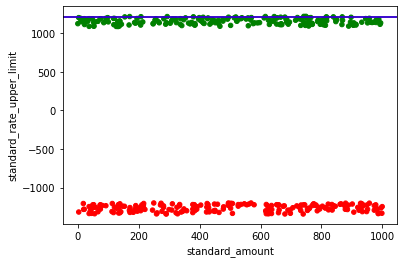

In [120]:
cols = ['']
plot_data = order_book[]

plt = order_book.plot.scatter(
    x='standard_amount',
    y='standard_rate_upper_limit',
    c=order_book['side'].replace({'BUY': 'green', 'SELL': 'red'}),
)
plt.axhline(y=reference_rate.rate, color='r', linestyle='-')
plt.axhline(y=clearing_price, color='blue', linestyle='-')